In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Importing data

In [2]:
accepted_loans = pd.read_csv('/content/drive/MyDrive/Lending Club Data/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [ ]:
accepted_loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
accepted_loans['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

# Exploratory Data Analysis

## Considering only 'Fully Paid' and 'Charged Off' status


In [3]:
accepted_loans = accepted_loans[(accepted_loans['loan_status'] == 'Fully Paid') | (accepted_loans['loan_status'] == 'Charged Off')]
accepted_loans.shape

(1345310, 151)

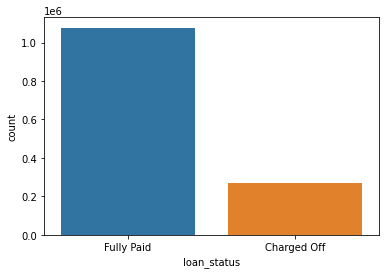

In [5]:
sns.countplot(x=accepted_loans['loan_status'], data=accepted_loans)

In [4]:
num_fully_paid_loans = accepted_loans[accepted_loans['loan_status'] == 'Fully Paid'].shape[0]
num_charged_off_loans = accepted_loans[accepted_loans['loan_status'] == 'Charged Off'].shape[0]
print(num_fully_paid_loans)
print(num_charged_off_loans)
print(num_fully_paid_loans / num_charged_off_loans)

1076751
268559
4.009364795072964


## Data Cleaning

### Percentage of missing values per column

In [5]:
accepted_loans.isnull().sum().sort_values(ascending=False)
# Can't compute percentage here because of ram limitation

next_pymnt_d                                  1345310
member_id                                     1345310
orig_projected_additional_accrued_interest    1341551
hardship_start_date                           1339556
hardship_length                               1339556
                                               ...   
pub_rec                                             0
open_acc                                            0
fico_range_high                                     0
fico_range_low                                      0
id                                                  0
Length: 151, dtype: int64

### Dropping features having too much missing data

In [6]:
# dropping columns have more than 50% missing data
keeping_columns = accepted_loans.columns[accepted_loans.isnull().sum() < (len(accepted_loans) / 2)].to_list()
len(keeping_columns)

93

In [7]:
accepted_loans = accepted_loans[keeping_columns]

In [9]:
(accepted_loans.isnull().sum() / len(accepted_loans) * 100).sort_values(ascending=False).head(50)

mths_since_recent_inq         12.939100
num_tl_120dpd_2m               8.726688
mo_sin_old_il_acct             7.847634
emp_title                      6.376597
emp_length                     5.835904
pct_tl_nvr_dlq                 5.030885
avg_cur_bal                    5.021073
num_rev_accts                  5.019512
mo_sin_rcnt_rev_tl_op          5.019512
mo_sin_old_rev_tl_op           5.019512
mo_sin_rcnt_tl                 5.019438
num_rev_tl_bal_gt_0            5.019438
num_accts_ever_120_pd          5.019438
num_actv_bc_tl                 5.019438
num_actv_rev_tl                5.019438
num_bc_tl                      5.019438
tot_coll_amt                   5.019438
total_rev_hi_lim               5.019438
num_op_rev_tl                  5.019438
num_il_tl                      5.019438
tot_cur_bal                    5.019438
tot_hi_cred_lim                5.019438
num_tl_op_past_12m             5.019438
total_il_high_credit_limit     5.019438
num_tl_30dpd                   5.019438


In [10]:
# dropping up to 'title' feature
dropping_columns = accepted_loans.isnull().sum().sort_values(ascending=False).head(37).index
accepted_loans = accepted_loans.drop(columns=dropping_columns)
accepted_loans.shape

(1345310, 56)

In [11]:
(accepted_loans.isnull().sum() / len(accepted_loans) * 100).sort_values(ascending=False)

last_pymnt_d                  0.171931
revol_util                    0.063703
pub_rec_bankruptcies          0.051810
dti                           0.027800
chargeoff_within_12_mths      0.004163
collections_12_mths_ex_med    0.004163
last_credit_pull_d            0.004088
tax_liens                     0.002899
inq_last_6mths                0.000074
zip_code                      0.000074
delinq_amnt                   0.000000
disbursement_method           0.000000
out_prncp_inv                 0.000000
total_pymnt                   0.000000
total_pymnt_inv               0.000000
total_rec_prncp               0.000000
total_rec_int                 0.000000
total_rec_late_fee            0.000000
recoveries                    0.000000
collection_recovery_fee       0.000000
acc_now_delinq                0.000000
hardship_flag                 0.000000
last_pymnt_amnt               0.000000
initial_list_status           0.000000
last_fico_range_high          0.000000
last_fico_range_low      

### Dropping rows with missing data

In [12]:
accepted_loans = accepted_loans.dropna()
accepted_loans.shape

(1341026, 56)

In [13]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341026 entries, 0 to 2260697
Data columns (total 56 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1341026 non-null  object 
 1   loan_amnt                   1341026 non-null  float64
 2   funded_amnt                 1341026 non-null  float64
 3   funded_amnt_inv             1341026 non-null  float64
 4   term                        1341026 non-null  object 
 5   int_rate                    1341026 non-null  float64
 6   installment                 1341026 non-null  float64
 7   grade                       1341026 non-null  object 
 8   sub_grade                   1341026 non-null  object 
 9   home_ownership              1341026 non-null  object 
 10  annual_inc                  1341026 non-null  float64
 11  verification_status         1341026 non-null  object 
 12  issue_d                     1341026 non-null  object 
 1

# Preprocessing

Plotting histogram of loan amout to see data distribution

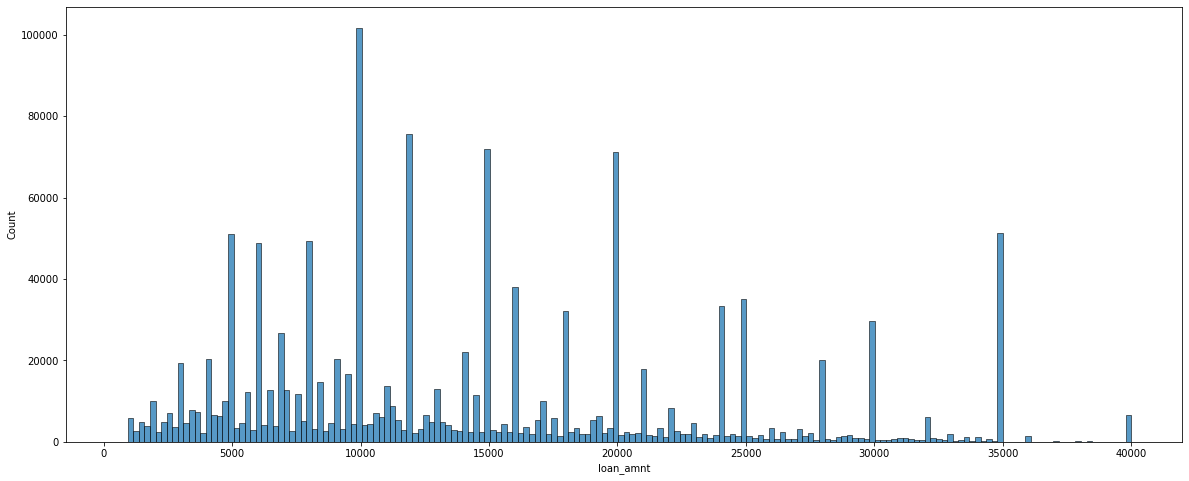

In [ ]:
plt.figure(figsize=(20, 8))
sns.histplot(accepted_loans['loan_amnt'])

## Seeing correlation between features via heatmap

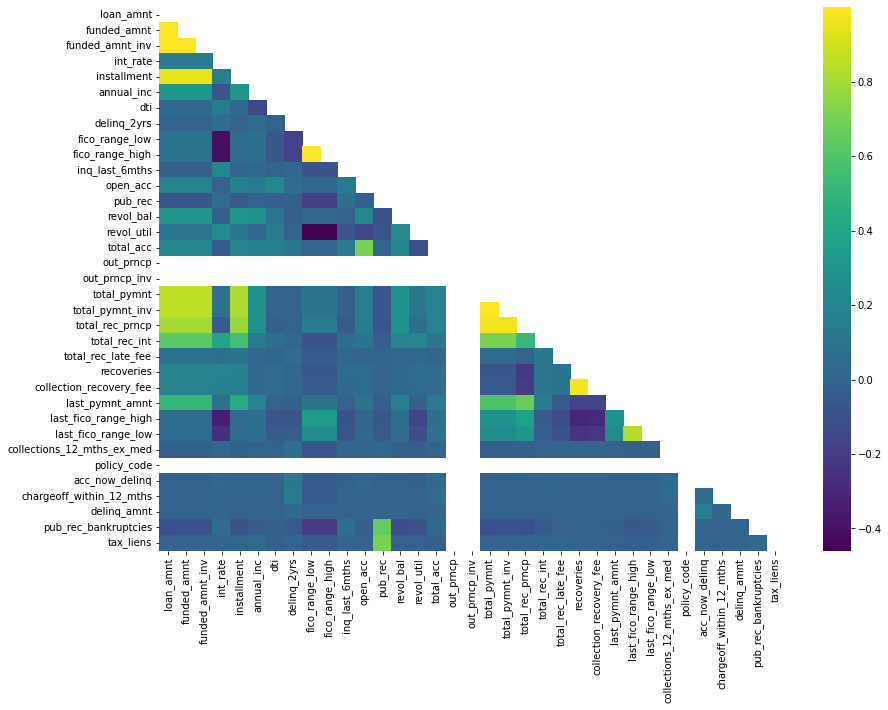

In [14]:
plt.figure(figsize=(14, 10))
mask = np.zeros_like(accepted_loans.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(accepted_loans.corr(), mask=mask, cmap='viridis')

There are 3 columns with a visible different behaviour: out_prncp, out_prncp_inv and policy_code

In [15]:
print(accepted_loans['out_prncp'].value_counts())
print(accepted_loans['out_prncp_inv'].value_counts())
print(accepted_loans['policy_code'].value_counts())

0.0    1341026
Name: out_prncp, dtype: int64
0.0    1341026
Name: out_prncp_inv, dtype: int64
1.0    1341026
Name: policy_code, dtype: int64


They are constant, so we can drop these features

In [16]:
dropping_columns = ['out_prncp', 'out_prncp_inv', 'policy_code']
accepted_loans = accepted_loans.drop(columns=dropping_columns)
accepted_loans.shape

(1341026, 53)

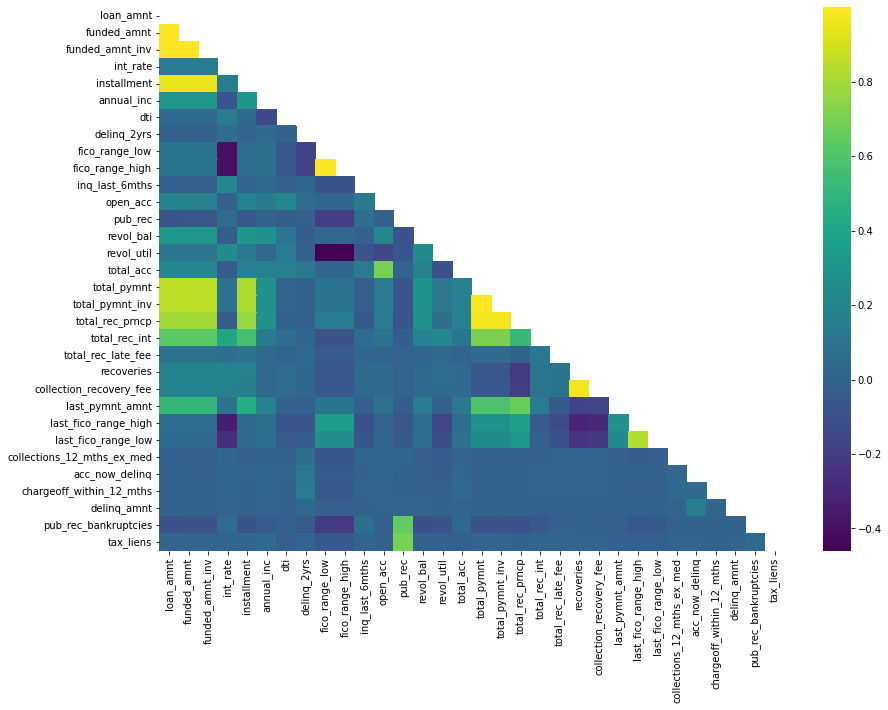

In [17]:
plt.figure(figsize=(14, 10))
mask = np.zeros_like(accepted_loans.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(accepted_loans.corr(), mask=mask, cmap='viridis')

Unstacking correlation to see highest correlation pairs

In [18]:
correlation_matrix = accepted_loans.corr().abs()
unstack_corr = correlation_matrix.unstack()
unstack_corr = unstack_corr.sort_values(ascending=False)

corr_df = pd.DataFrame(unstack_corr).drop_duplicates().reset_index()
corr_df.columns = ['feature 1', 'feature 2', 'corr']

# check pairs of feature having corr > 0.8
condition1 = corr_df['corr'] > 0.8
condition2 = corr_df['feature 1'] != corr_df['feature 2']
corr_df[condition1 & condition2]

,feature 1,feature 2,corr
1,fico_range_low,fico_range_high,1.000000
2,funded_amnt,loan_amnt,0.999565
3,total_pymnt_inv,total_pymnt,0.999541
4,funded_amnt_inv,funded_amnt,0.999439
5,funded_amnt_inv,loan_amnt,0.998918
6,recoveries,collection_recovery_fee,0.972674
7,total_pymnt,total_rec_prncp,0.967104
8,total_rec_prncp,total_pymnt_inv,0.966725
9,funded_amnt,installment,0.954037
10,installment,funded_amnt_inv,0.953445


## Performing scatter plot to check some correlations between variables

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


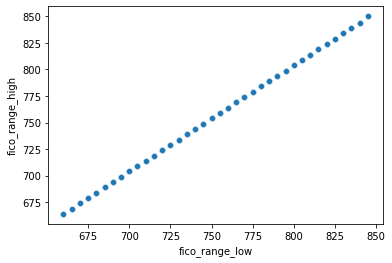

In [ ]:
sns.scatterplot(accepted_loans['fico_range_low'], accepted_loans['fico_range_high'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


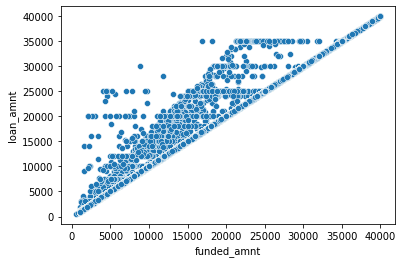

In [ ]:
sns.scatterplot(accepted_loans['funded_amnt'], accepted_loans['loan_amnt'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


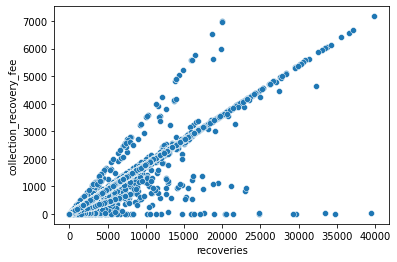

In [ ]:
sns.scatterplot(accepted_loans['recoveries'], accepted_loans['collection_recovery_fee'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


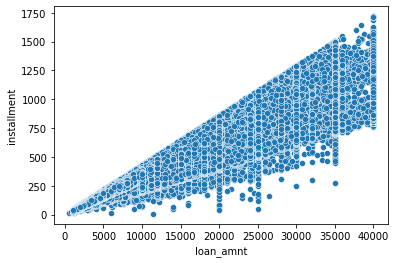

In [ ]:
sns.scatterplot(accepted_loans['loan_amnt'], accepted_loans['installment'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


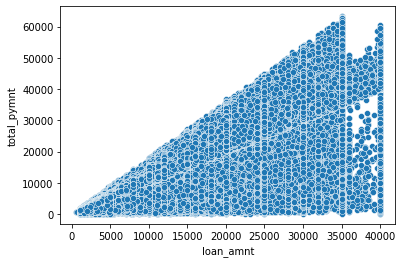

In [ ]:
sns.scatterplot(accepted_loans['loan_amnt'], accepted_loans['total_pymnt'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


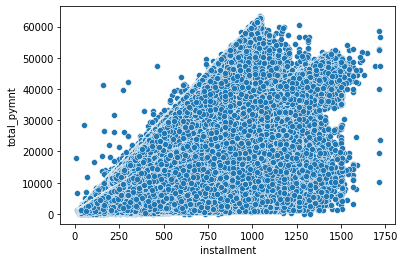

In [ ]:
sns.scatterplot(accepted_loans['installment'], accepted_loans['total_pymnt'])

Let's drop some columns because of duplicated information

In [19]:
dropping_columns = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
accepted_loans = accepted_loans.drop(columns=dropping_columns)
accepted_loans.shape

(1341026, 44)

## Creating a new feature - loan_paid - that is 1 for 'Fully Paid' and 0 for 'Charged Off'

In [20]:
accepted_loans['loan_paid'] = accepted_loans['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)
accepted_loans = accepted_loans.drop(columns=['loan_status'])

## Working on categorical features

In [21]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341026 entries, 0 to 2260697
Data columns (total 44 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1341026 non-null  object 
 1   loan_amnt                   1341026 non-null  float64
 2   term                        1341026 non-null  object 
 3   int_rate                    1341026 non-null  float64
 4   grade                       1341026 non-null  object 
 5   sub_grade                   1341026 non-null  object 
 6   home_ownership              1341026 non-null  object 
 7   annual_inc                  1341026 non-null  float64
 8   verification_status         1341026 non-null  object 
 9   issue_d                     1341026 non-null  object 
 10  pymnt_plan                  1341026 non-null  object 
 11  url                         1341026 non-null  object 
 12  purpose                     1341026 non-null  object 
 1

In [22]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))
accepted_loans[categorical_columns]

Index(['id', 'term', 'grade', 'sub_grade', 'home_ownership',
       'verification_status', 'issue_d', 'pymnt_plan', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'hardship_flag', 'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
20


,id,term,grade,sub_grade,home_ownership,verification_status,issue_d,pymnt_plan,url,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,36 months,C,C4,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,190xx,PA,Aug-2003,w,Jan-2019,Mar-2019,Individual,N,Cash,N
1,68355089,36 months,C,C1,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,577xx,SD,Dec-1999,w,Jun-2016,Mar-2019,Individual,N,Cash,N
2,68341763,60 months,B,B4,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,605xx,IL,Aug-2000,w,Jun-2017,Mar-2019,Joint App,N,Cash,N
4,68476807,60 months,F,F1,MORTGAGE,Source Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,174xx,PA,Jun-1998,w,Jul-2016,Mar-2018,Individual,N,Cash,N
5,68426831,36 months,C,C3,RENT,Source Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,300xx,GA,Oct-1987,w,May-2017,May-2017,Individual,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,89905081,60 months,B,B2,OWN,Not Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,775xx,TX,Jul-2004,f,Aug-2018,Mar-2019,Individual,N,Cash,N
2260690,88948836,60 months,C,C3,MORTGAGE,Not Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,900xx,CA,Mar-2002,f,Jul-2018,Jul-2018,Individual,N,Cash,N
2260691,89996426,60 months,C,C4,MORTGAGE,Source Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,863xx,AZ,Jun-2011,f,Mar-2017,Dec-2018,Individual,N,Cash,N
2260692,90006534,60 months,C,C1,RENT,Not Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,medical,284xx,NC,Aug-1997,f,Mar-2018,Mar-2019,Individual,N,Cash,N


### Dropping features 'id', 'pymnt_plan' and 'hardship_flag'

In [23]:
# constant features (pymnt_plan and hardship_flag)
print(accepted_loans['pymnt_plan'].value_counts())
print(accepted_loans['hardship_flag'].value_counts())

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64


In [24]:
dropping_columns = ['id', 'pymnt_plan', 'hardship_flag']
accepted_loans = accepted_loans.drop(columns=dropping_columns)
accepted_loans.shape

(1341026, 41)

In [25]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(len(categorical_columns))
print(categorical_columns)

17
Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')


### Features 'term'

In [26]:
print(accepted_loans['term'].value_counts())

 36 months    1017398
 60 months     323628
Name: term, dtype: int64


In [27]:
# convert term into either a 36 or 60 integer numeric data type
accepted_loans['term'] = accepted_loans['term'].apply(lambda x: 36 if x == '36 months' else 60) 
accepted_loans['term']

0          60
1          60
2          60
4          60
5          60
           ..
2260688    60
2260690    60
2260691    60
2260692    60
2260697    60
Name: term, Length: 1341026, dtype: int64

In [28]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))

Index(['grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
16


### Features "grade" and "sub_grade"

In [29]:
print(accepted_loans['grade'].value_counts())

B    391850
C    380490
A    234657
D    200019
E     93126
F     31854
G      9030
Name: grade, dtype: int64


In [30]:
print(accepted_loans['sub_grade'].value_counts())

C1    85247
B4    83003
B5    82327
B3    81658
C2    78960
C3    74781
C4    74173
B2    73870
B1    70992
C5    67329
A5    63892
A4    52135
D1    51092
D2    44637
A1    43634
D3    39134
A3    37900
A2    37096
D4    35412
D5    29744
E1    23657
E2    21244
E3    18279
E4    15621
E5    14325
F1     9914
F2     7149
F3     6055
F4     4826
F5     3910
G1     2967
G2     2109
G3     1600
G4     1259
G5     1095
Name: sub_grade, dtype: int64


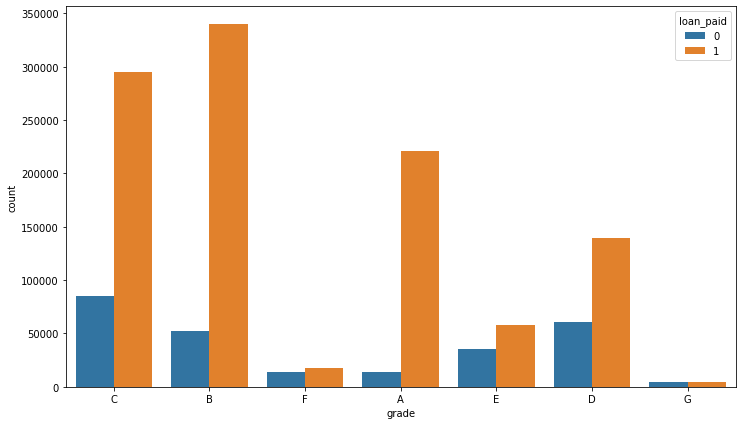

In [31]:
# checking count per grade and loan_paid
plt.figure(figsize=(12, 7))
sns.countplot(x=accepted_loans['grade'], hue=accepted_loans['loan_paid'])

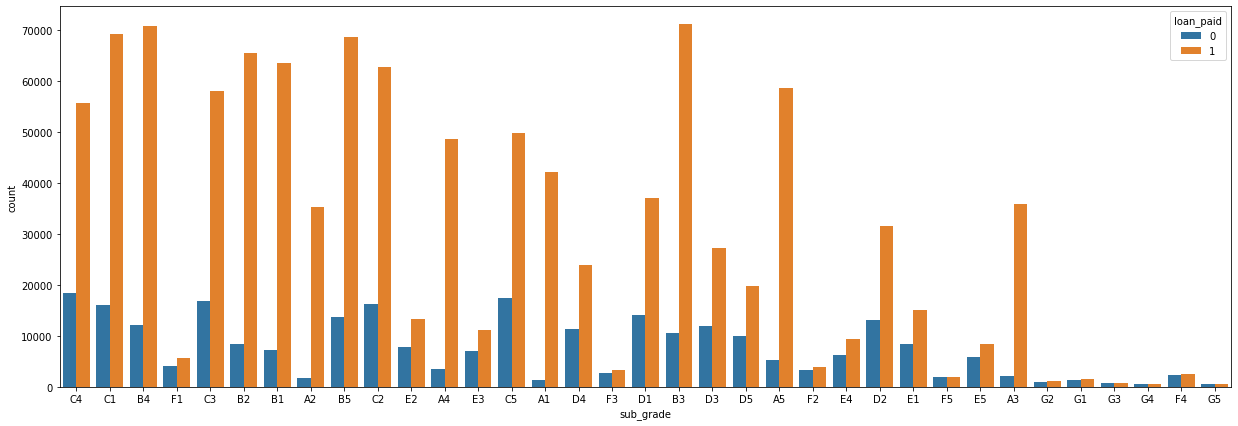

In [ ]:
# checking count per subgrade and loan_paid
plt.figure(figsize=(21, 7))
sns.countplot(x=accepted_loans['sub_grade'], hue=accepted_loans['loan_paid'])

In [32]:
# Since grade is part of sub_grade, so let's just drop the grade feature
accepted_loans.drop('grade', axis=1, inplace=True)

In [33]:
accepted_loans.shape

(1341026, 40)

In [34]:
accepted_loans = pd.get_dummies(accepted_loans, columns=['sub_grade'], prefix='sub_grade', prefix_sep='_', drop_first=True)

In [35]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))

Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
14


### Features 'verification_status', 'purpose', 'application_type', 'initial_list_status' and 'home_ownership'

In [36]:
dummies = ['verification_status', 'purpose', 'initial_list_status', 'application_type', 'home_ownership']
for dummy_var in dummies:
  print(accepted_loans[dummy_var].unique())

['Not Verified' 'Source Verified' 'Verified']
['debt_consolidation' 'small_business' 'home_improvement' 'major_purchase'
 'credit_card' 'other' 'house' 'vacation' 'car' 'medical' 'moving'
 'renewable_energy' 'wedding' 'educational']
['w' 'f']
['Individual' 'Joint App']
['MORTGAGE' 'RENT' 'OWN' 'ANY' 'NONE' 'OTHER']


For these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

In [37]:
for dummy_var in dummies:
  accepted_loans = pd.get_dummies(accepted_loans, prefix=dummy_var, columns=[dummy_var], drop_first=True)

In [38]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))

Index(['issue_d', 'url', 'zip_code', 'addr_state', 'earliest_cr_line',
       'last_pymnt_d', 'last_credit_pull_d', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
9


### Features 'issue_d', 'url', 'last_pymnt_d' and 'last_credit_pull_d'

In [39]:
print(accepted_loans['issue_d'].value_counts())

Mar-2016    48828
Oct-2015    42948
Jul-2015    40995
Dec-2015    38950
Oct-2014    36018
            ...  
Feb-2008        7
Jan-2008        6
Nov-2007        2
Dec-2007        2
Oct-2007        1
Name: issue_d, Length: 135, dtype: int64


In [ ]:
print(accepted_loans['url'].value_counts())

https://lendingclub.com/browse/loanDetail.action?loan_id=68407277     1
https://lendingclub.com/browse/loanDetail.action?loan_id=143889346    1
https://lendingclub.com/browse/loanDetail.action?loan_id=144187055    1
https://lendingclub.com/browse/loanDetail.action?loan_id=143508756    1
https://lendingclub.com/browse/loanDetail.action?loan_id=144206887    1
                                                                     ..
https://lendingclub.com/browse/loanDetail.action?loan_id=81376539     1
https://lendingclub.com/browse/loanDetail.action?loan_id=82257177     1
https://lendingclub.com/browse/loanDetail.action?loan_id=82020311     1
https://lendingclub.com/browse/loanDetail.action?loan_id=82010251     1
https://lendingclub.com/browse/loanDetail.action?loan_id=88224441     1
Name: url, Length: 1341026, dtype: int64


In [ ]:
print(accepted_loans['last_credit_pull_d'].value_counts())

Mar-2019    469669
Feb-2019     74703
Jan-2019     61192
Jul-2018     53396
Oct-2016     50113
             ...  
Dec-2008         3
Sep-2008         3
Aug-2008         3
Jun-2008         1
Apr-2019         1
Name: last_credit_pull_d, Length: 131, dtype: int64


Let's drop these features

In [40]:
dropping_columns = ['issue_d', 'url', 'last_pymnt_d', 'last_credit_pull_d']
accepted_loans = accepted_loans.drop(columns=dropping_columns)

In [42]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))

Index(['zip_code', 'addr_state', 'earliest_cr_line', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
5


### Features 'disbursement_method' and 'debt_settlement_flag'

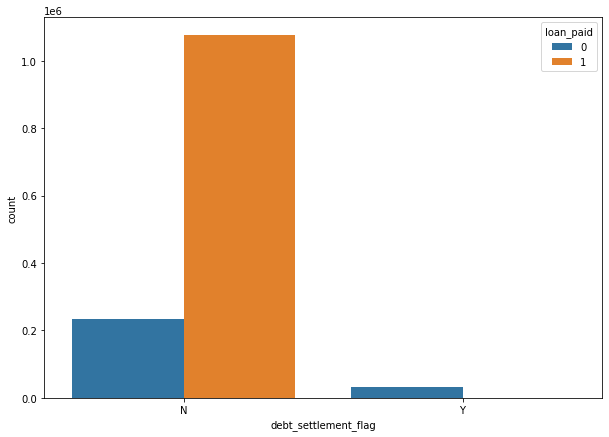

In [43]:
plt.figure(figsize=(10, 7))
sns.countplot(x=accepted_loans['debt_settlement_flag'], hue=accepted_loans['loan_paid'])

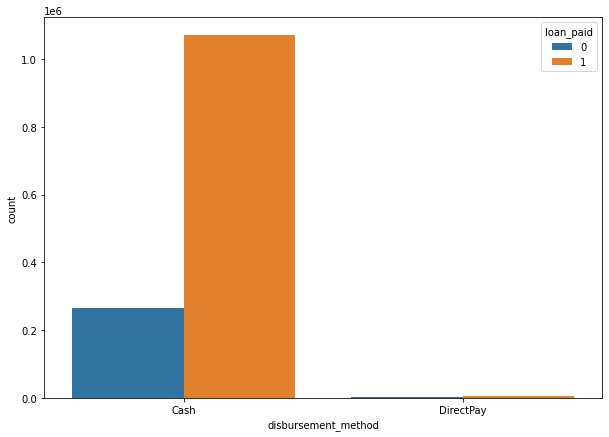

In [44]:
plt.figure(figsize=(10, 7))
sns.countplot(x=accepted_loans['disbursement_method'], hue=accepted_loans['loan_paid'])

In [ ]:
print(accepted_loans['disbursement_method'].value_counts())
print(accepted_loans['debt_settlement_flag'].value_counts())

Cash         1334162
DirectPay       6864
Name: disbursement_method, dtype: int64
N    1307844
Y      33182
Name: debt_settlement_flag, dtype: int64


It seem that these features can cause data leakage, but I will get dummies first

In [45]:
#accepted_loans = pd.get_dummies(accepted_loans, columns = ['disbursement_method'], prefix='disbursement_method', drop_first=True)
#accepted_loans = pd.get_dummies(accepted_loans, columns = ['debt_settlement_flag'], prefix='debt_settlement_flag', drop_first=True)
dropping_columns = ['disbursement_method', 'debt_settlement_flag']
accepted_loans = accepted_loans.drop(columns=dropping_columns)

In [46]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))

Index(['zip_code', 'addr_state', 'earliest_cr_line'], dtype='object')
3


### Features 'zip_code' and 'addr_state'

In [47]:
print(accepted_loans['zip_code'].value_counts())

945xx    14964
750xx    14440
112xx    13781
606xx    12407
300xx    12087
         ...  
269xx        1
009xx        1
849xx        1
513xx        1
525xx        1
Name: zip_code, Length: 943, dtype: int64


In [48]:
# Drop 'zip_code' feature
accepted_loans = accepted_loans.drop(columns=['zip_code'])

In [49]:
print(accepted_loans['addr_state'].unique())
print(len(accepted_loans['addr_state'].unique()))

['PA' 'SD' 'IL' 'GA' 'MN' 'SC' 'RI' 'NC' 'CA' 'VA' 'AZ' 'IN' 'MD' 'NY'
 'TX' 'KS' 'NM' 'AL' 'WA' 'OH' 'LA' 'FL' 'CO' 'MI' 'MO' 'DC' 'MA' 'WI'
 'HI' 'VT' 'NJ' 'DE' 'TN' 'NH' 'NE' 'OR' 'CT' 'AR' 'NV' 'WV' 'MT' 'WY'
 'OK' 'KY' 'MS' 'UT' 'ND' 'ME' 'AK' 'ID' 'IA']
51


51 states :::)))

The 51st state may be the state of aliens :::)))

Let's first drop this feature also

In [50]:
#accepted_loans = accepted_loans.drop(columns=['addr_state'])
accepted_loans = pd.get_dummies(accepted_loans, columns=['addr_state'], prefix='addr_state', drop_first=True)

In [51]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))

Index(['earliest_cr_line'], dtype='object')
1


In [ ]:
accepted_loans.drop('emp_title', axis=1, inplace=True)

In [ ]:
accepted_loans.drop('title', axis=1, inplace=True)

In [ ]:
accepted_loans.drop('emp_length', axis=1, inplace=True)

In [ ]:
accepted_loans.drop('issue_d', axis=1, inplace=True)

### Feature 'earliest_cr_line'

In [52]:
print(len(accepted_loans['earliest_cr_line'].unique()))

739


Can extract year or month part of this feature to observe seasonal effect but first I will drop it

In [53]:
accepted_loans = accepted_loans.drop(columns=['earliest_cr_line'])

In [54]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341026 entries, 0 to 2260697
Columns: 131 entries, loan_amnt to addr_state_WY
dtypes: float64(23), int64(2), uint8(106)
memory usage: 401.6 MB


# Model Building and Training

## ANN

### Features and labels

In [55]:
features = accepted_loans.loc[:, accepted_loans.columns != 'loan_paid'].values
labels = accepted_loans['loan_paid'].values

### Train test split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

### Min max scalar

In [57]:
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [58]:
accepted_loans.shape

(1341026, 131)

In [59]:
print(X_train.shape)
print(X_test.shape)

(1072820, 130)
(268206, 130)


### Building model

In [63]:
model = Sequential()

model = Sequential()
model.add(Dense(units=78,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=39,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=19,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=8,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=4,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

### Traning

In [64]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=40,
          batch_size=512,
          verbose=1)

Epoch 1/40
2096/2096 [==============================] - 15s 6ms/step - loss: 0.1687
Epoch 2/40
2096/2096 [==============================] - 12s 6ms/step - loss: 0.1073
Epoch 3/40
2096/2096 [==============================] - 12s 6ms/step - loss: 0.0970
Epoch 4/40
2096/2096 [==============================] - 12s 6ms/step - loss: 0.0913
Epoch 5/40
2096/2096 [==============================] - 12s 6ms/step - loss: 0.0870
Epoch 6/40
2096/2096 [==============================] - 12s 6ms/step - loss: 0.0840
Epoch 7/40
2096/2096 [==============================] - 12s 5ms/step - loss: 0.0817
Epoch 8/40
2096/2096 [==============================] - 12s 6ms/step - loss: 0.0782
Epoch 9/40
2096/2096 [==============================] - 11s 5ms/step - loss: 0.0756
Epoch 10/40
2096/2096 [==============================] - 12s 6ms/step - loss: 0.0728
Epoch 11/40
2096/2096 [==============================] - 12s 6ms/step - loss: 0.0704
Epoch 12/40
2096/2096 [==============================] - 12s 6ms/step - lo

## Model Evaluating

In [60]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [65]:
losses = pd.DataFrame(model.history.history)

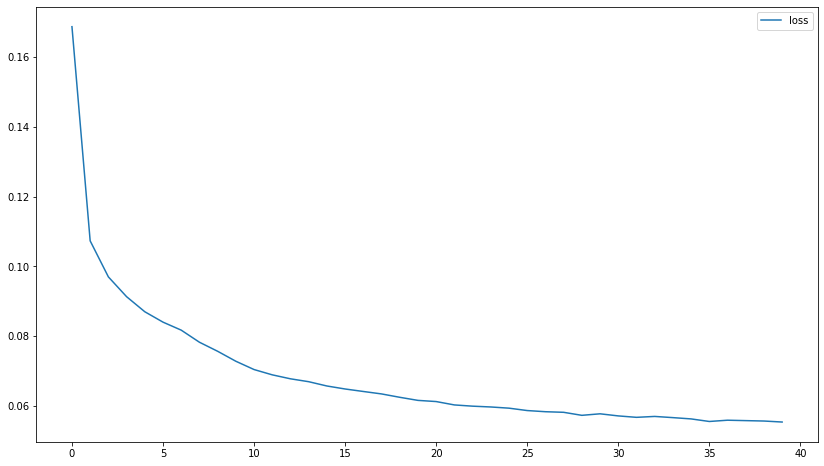

In [67]:
losses[['loss']].plot(figsize=(14, 8))

In [69]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
print_score(y_test, predictions, train=False)

Test Result:
Accuracy Score: 98.35%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.976891       0.985041   0.98349       0.980966       0.983427
recall         0.938801       0.994519   0.98349       0.966660       0.983490
f1-score       0.957467       0.989757   0.98349       0.973612       0.983366
support    53089.000000  215117.000000   0.98349  268206.000000  268206.000000
_______________________________________________
Confusion Matrix: 
 [[ 49840   3249]
 [  1179 213938]]



## RandomForest

In [70]:
from sklearn.ensemble import RandomForestClassifier

In [71]:
rf_clf = RandomForestClassifier(n_estimators=100)

In [72]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [73]:
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

In [74]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       1.000000       0.999999  0.999999  9.999994e-01  9.999991e-01
recall          0.999995       1.000000  0.999999  9.999977e-01  9.999991e-01
f1-score        0.999998       0.999999  0.999999  9.999985e-01  9.999991e-01
support    212791.000000  860029.000000  0.999999  1.072820e+06  1.072820e+06
_______________________________________________
Confusion Matrix: 
 [[212790      1]
 [     0 860029]]

Test Result:
Accuracy Score: 98.00%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.965348       0.983478  0.980012       0.974413       0.979889
recall         0.932491       0.991739  0.980012       0.962115       0.980012
f1-score       0.948635       0.987591  0.980012     

## Logistic regression

In [75]:
from sklearn.linear_model import LogisticRegression

In [76]:
clf = LogisticRegression()

In [77]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [78]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [79]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 95.90%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       0.904148       0.972217  0.958969  9.381823e-01  9.587157e-01
recall          0.887190       0.976729  0.958969  9.319592e-01  9.589689e-01
f1-score        0.895588       0.974468  0.958969  9.350280e-01  9.588222e-01
support    212791.000000  860029.000000  0.958969  1.072820e+06  1.072820e+06
_______________________________________________
Confusion Matrix: 
 [[188786  24005]
 [ 20014 840015]]

Test Result:
Accuracy Score: 95.94%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.903813       0.972810  0.959371       0.938312       0.959153
recall         0.889393       0.976641  0.959371       0.933017       0.959371
f1-score       0.896545       0.974722  0.959371      